In [117]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from utils.dataio import *
from utils.visualization import *

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/'

### Load data

In [118]:
config = load_config('../config.yaml')
n_samples = 5
lr_nf = 5e-3

In [119]:
ip_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
ip_gt = standardize(ip_gt)
data_range_ip = 13 # ip_gt.max() - ip_gt.min()
data_range_sos = 150

DAS.

In [120]:
v_das_list = [1510, 1510, 1508, 1505, 1508]
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(v_das_list))) for _ in range(5)]

for sample_id, v_das in enumerate(v_das_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    params = f'v_das={v_das:.1f}m·s⁻¹'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'DAS', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'log.json'))
    ip_psnrs[sample_id] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
    ip_ssims[sample_id] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
    times[sample_id] = log['time']

In [121]:
print('DAS')
print('IP PSNR:', ip_psnrs.mean().round(2))
print('IP SSIM:', ip_ssims.mean().round(3))
print('Time:', times.mean().round(2))

DAS
IP PSNR: 19.79
IP SSIM: 0.441
Time: 0.12


Dual-SOS DAS.

In [122]:
v_body_list = [1560, 1570, 1547, 1537, 1548]
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(v_das_list))) for _ in range(5)]

for sample_id, v_body in enumerate(v_body_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    params = f'v_body={v_body:.1f}m·s⁻¹'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'Dual-SOS_DAS', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'log.json'))
    ip_psnrs[sample_id] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
    ip_ssims[sample_id] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
    times[sample_id] = log['time']

In [123]:
print('Dual-SOS DAS')
print('IP PSNR:', ip_psnrs.mean().round(2))
print('IP SSIM:', ip_ssims.mean().round(3))
print('Time:', times.mean().round(2))

Dual-SOS DAS
IP PSNR: 24.64
IP SSIM: 0.535
Time: 0.12


### Number of delays 

In [124]:
n_delays_list = [64,32,16,8,4,2]
n_delays_list.sort()

APACT.

In [125]:
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    # data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'APACT', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[sample_id, idx] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[sample_id, idx] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[sample_id, idx] = log['time']

In [126]:
print('APACT')
print('IP PSNR:', ip_psnrs.mean(0).round(2))
print('IP SSIM:', ip_ssims.mean(0).round(3))
print('SOS PSNR:', sos_psnrs.mean(0).round(2))
print('SOS SSIM:', sos_ssims.mean(0).round(3))
print('Time:', times.mean(0).round(1))

APACT
IP PSNR: [19.67 19.68 19.75 19.73 19.73 19.73]
IP SSIM: [0.111 0.304 0.394 0.445 0.45  0.451]
SOS PSNR: [16.19 17.93 17.05 17.41 17.34 17.24]
SOS SSIM: [0.91  0.895 0.888 0.89  0.889 0.89 ]
Time: [ 699.7  843.5  988.8 1409.8 2429.1 4541. ]


Pixel Grid.

In [127]:
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    # data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays_TV={1e-4:.1e}_{10}epochs_bs={64}_lr={0.1:.1e}'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'PG', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[sample_id, idx] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[sample_id, idx] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[sample_id, idx] = log['time']

In [128]:
print('PG + TV')
print('IP PSNR:', ip_psnrs.mean(0).round(2))
print('IP SSIM:', ip_ssims.mean(0).round(3))
print('SOS PSNR:', sos_psnrs.mean(0).round(2))
print('SOS SSIM:', sos_ssims.mean(0).round(3))
print('Time:', times.mean(0).round(1))

PG + TV
IP PSNR: [23.56 24.69 25.28 25.37 25.43 25.39]
IP SSIM: [0.225 0.391 0.494 0.538 0.556 0.556]
SOS PSNR: [20.08 20.61 21.22 21.45 21.45 21.42]
SOS SSIM: [0.832 0.875 0.876 0.876 0.877 0.877]
Time: [ 20.4  24.   32.8  66.9  79.5 126.4]


NF-APACT.

In [129]:
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    # data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays_{0}lyrs_{128}fts_{10}epochs_bs={64}_lr={lr_nf:.1e}'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[sample_id, idx] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[sample_id, idx] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[sample_id, idx] = log['time']

In [130]:
print('NF-APACT')
print('IP PSNR:', ip_psnrs.mean(0).round(2))
print('IP SSIM:', ip_ssims.mean(0).round(3))
print('SOS PSNR:', sos_psnrs.mean(0).round(2))
print('SOS SSIM:', sos_ssims.mean(0).round(3))
print('Time:', times.mean(0).round(1))

NF-APACT
IP PSNR: [23.64 24.96 25.24 25.4  25.32 25.34]
IP SSIM: [0.229 0.387 0.493 0.54  0.554 0.555]
SOS PSNR: [20.49 21.16 21.47 21.54 21.59 21.31]
SOS SSIM: [0.936 0.933 0.931 0.933 0.933 0.935]
Time: [ 16.9  20.1  26.5  39.8  66.1 118.7]


Multi-channel Deconvolution.

In [131]:
ip_psnrs, ip_ssims, times = [np.zeros((n_samples, len(n_delays_list))) for _ in range(3)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    # data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays_bs={64}'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'Deconv', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        times[sample_id, idx] = log['time']

In [132]:
print('MC Deconv')
print('IP PSNR:', ip_psnrs.mean(0).round(2))
print('IP SSIM:', ip_ssims.mean(0).round(3))
print('Time:', times.mean(0).round(1))

MC Deconv
IP PSNR: [23.73 25.57 26.04 26.45 26.54 26.54]
IP SSIM: [0.224 0.365 0.485 0.572 0.596 0.597]
Time: [0.6 0.9 1.5 2.7 5.  9.6]


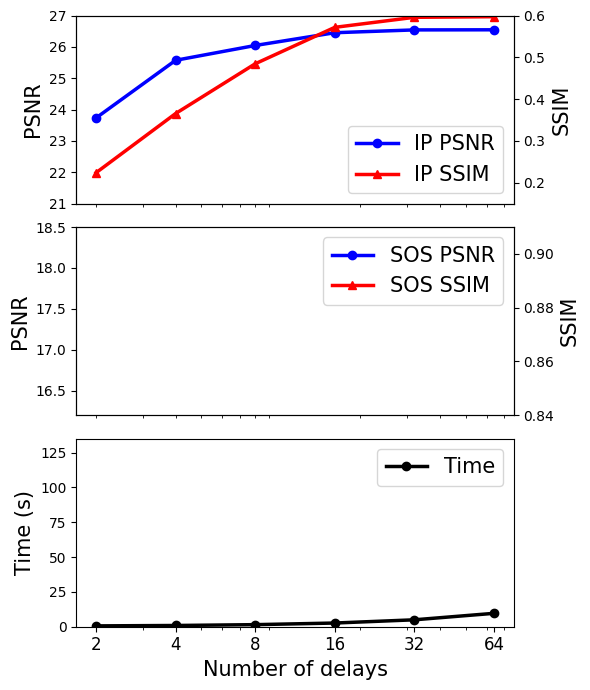

In [133]:
fig = plt.figure(figsize=(6,7))
ax1 = plt.subplot(3,1,1)
ax2 = ax1.twinx()
line_psnr = ax1.plot(n_delays_list, np.mean(ip_psnrs, axis=0), label='IP PSNR', marker='o', color='blue', linewidth=2.5)
line_ssim = ax2.plot(n_delays_list, np.mean(ip_ssims, axis=0), label='IP SSIM', marker='^', color='red', linewidth=2.5)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([21, 27])
ax2.set_ylim([0.15, 0.6])
ax1.set_xscale('log')
ax1.set_xticks([])
lns = line_psnr + line_ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc='lower right')

ax1 = plt.subplot(3,1,2)
ax2 = ax1.twinx()
line_psnr = ax1.plot(n_delays_list, np.mean(sos_psnrs,axis=0), label='SOS PSNR', marker='o', color='blue', linewidth=2.5)
line_ssim = ax2.plot(n_delays_list, np.mean(sos_ssims,axis=0), label='SOS SSIM', marker='^', color='red', linewidth=2.5)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([16.2, 18.5])
ax2.set_ylim([0.84, 0.91])
ax1.set_xscale('log')
ax1.set_xticks([])
lns = line_psnr + line_ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15)

ax = plt.subplot(3,1,3)
ax.plot(n_delays_list, np.mean(times, axis=0), label='Time', marker='o', color='black', linewidth=2.5)
ax.set_ylim([0, 135])
ax.set_xscale('log')
ax.set_ylabel('Time (s)', fontsize=15)
ax.set_xticks([2,4,8,16,32,64], ['2','4','8','16','32','64'], fontsize=12)
ax.set_xlabel('Number of delays', fontsize=15)
ax.legend(fontsize=15)

plt.tight_layout()
# plt.savefig('figure_ablation_delays.png', bbox_inches='tight', dpi=128)

### TV Regularization weight

In [134]:
lam_tv_list = [1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3]
lam_tv_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(lam_tv_list))) for _ in range(5)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    # data_range_sos = sos_gt.max() - sos_gt.min()
    for idx, lam_tv in enumerate(lam_tv_list):
        if lam_tv == 0:
            params = '{}delays_{}epochs_bs={}_lr={:.1e}'.format(16, 10, 64, 1e-1)
        else:
            params = '{}delays_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(16, lam_tv, 10, 64, 1e-1)
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'PG', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[sample_id, idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[sample_id, idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[sample_id, idx] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[sample_id, idx] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[sample_id, idx] = log['time']

In [135]:
print('IP PSNR:', ip_psnrs.mean(0).round(2))
print('IP SSIM:', ip_ssims.mean(0).round(3))
print('SOS PSNR:', sos_psnrs.mean(0).round(2))

IP PSNR: [25.29 25.34 25.4  25.37 25.37 25.32 25.13]
IP SSIM: [0.537 0.538 0.54  0.538 0.538 0.535 0.528]
SOS PSNR: [18.34 20.16 21.06 21.45 21.36 21.07 20.61]


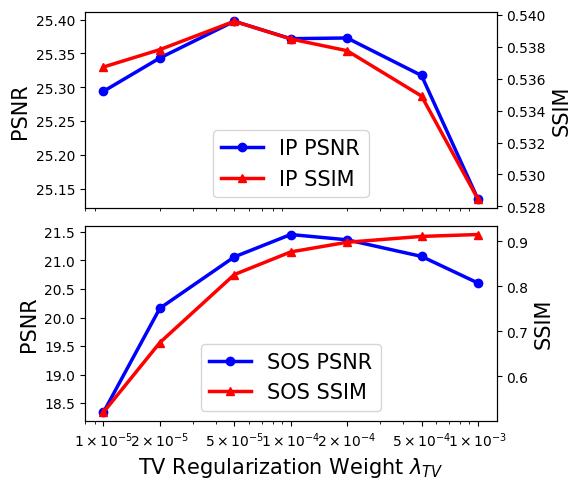

In [136]:
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(2,1,1)
ax2 = ax1.twinx()
line_psnr = ax1.plot(lam_tv_list, ip_psnrs.mean(0), label='IP PSNR', marker='o', color='blue', linewidth=2.5)
line_ssim = ax2.plot(lam_tv_list, ip_ssims.mean(0), label='IP SSIM', marker='^', color='red', linewidth=2.5)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
# ax1.set_ylim([18.2, 18.6])
# ax2.set_ylim([0.439, 0.450])
ax1.set_xscale('log')
ax1.set_xticks([])
lns = line_psnr + line_ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc='lower center')

ax1 = plt.subplot(2,1,2)
ax2 = ax1.twinx()
line_psnr = ax1.plot(lam_tv_list, sos_psnrs.mean(0), label='SOS PSNR', marker='o', color='blue', linewidth=2.5)
line_ssim = ax2.plot(lam_tv_list, sos_ssims.mean(0), label='SOS SSIM', marker='^', color='red', linewidth=2.5)
# ax.set_ylim([16.5, 17.7])
ax1.set_xscale('log')
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
ax1.set_xticks([1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3], 
              [r'$1\times10^{-5}$', r'$2\times10^{-5}$', r'$5\times10^{-5}$', r'$1\times10^{-4}$', r'$2\times10^{-4}$', r'$5\times10^{-4}$', r'$1\times10^{-3}$'],
              fontsize=10)
ax1.set_xlabel('TV Regularization Weight $\lambda_{TV}$', fontsize=15)
lns = line_psnr + line_ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc='lower center')

plt.tight_layout()
# plt.savefig('figure_ablation_lam_tv.png', bbox_inches='tight', dpi=128)

### Network structure

In [137]:
hidden_fts_list = [16,32,64,128, 256]
hidden_fts_list.sort()
hidden_lyrs_list = [0,1]
hidden_lyrs_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times, n_params = [np.zeros((n_samples, len(hidden_lyrs_list), len(hidden_fts_list))) for _ in range(6)]

for sample_id in range(n_samples):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    # data_range_sos = sos_gt.max() - sos_gt.min()
    for i, hidden_lyrs in enumerate(hidden_lyrs_list):
        for j, hidden_fts in enumerate(hidden_fts_list):
            params = '{}delays_{}lyrs_{}fts_{}epochs_bs={}_lr={:.1e}'.format(16, hidden_lyrs, hidden_fts, 10, 64, lr_nf)
            results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
            ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
            sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
            ip_rec = standardize(ip_rec)
            log = load_log(os.path.join(results_path, 'log.json'))
            ip_psnrs[sample_id, i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
            ip_ssims[sample_id, i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
            sos_psnrs[sample_id, i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
            sos_ssims[sample_id, i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
            times[sample_id, i, j] = log['time']
            n_params[sample_id, i, j] = log['n_params']

In [138]:
print('IP PSNR (0HL):', ip_psnrs[:,0,:].mean(0).round(2))
print('IP PSNR (1HL):', ip_psnrs[:,1,:].mean(0).round(2))
print('IP SSIM (0HL):', ip_ssims[:,0,:].mean(0).round(3))
print('IP SSIM (1HL):', ip_ssims[:,1,:].mean(0).round(3))
print('SOS PSNR (0HL):', sos_psnrs[:,0,:].mean(0).round(2))
print('SOS PSNR (1HL):', sos_psnrs[:,1,:].mean(0).round(2))
print('SOS SSIM (0HL):', sos_ssims[:,0,:].mean(0).round(3))
print('SOS SSIM (1HL):', sos_ssims[:,1,:].mean(0).round(3))
print('Time (0HL):', times[:,0,:].mean(0).round(2))
print('Time (1HL):', times[:,1,:].mean(0).round(2))
print('Params (0HL):', n_params[0,0,:].astype(int))
print('Params (1HL):', n_params[0,1,:].astype(int))

IP PSNR (0HL): [24.84 25.31 25.32 25.4  25.32]
IP PSNR (1HL): [25.05 25.29 25.24 24.87 24.42]
IP SSIM (0HL): [0.509 0.537 0.539 0.54  0.537]
IP SSIM (1HL): [0.525 0.538 0.536 0.526 0.51 ]
SOS PSNR (0HL): [19.15 21.92 21.65 21.54 21.3 ]
SOS PSNR (1HL): [18.96 21.09 20.27 16.04 13.36]
SOS SSIM (0HL): [0.93  0.945 0.939 0.933 0.931]
SOS SSIM (1HL): [0.856 0.876 0.774 0.477 0.406]
Time (0HL): [39.63 39.72 39.81 39.8  40.09]
Time (1HL): [39.73 39.79 39.95 40.15 40.83]
Params (0HL): [  67  131  259  515 1027]
Params (1HL): [  339  1187  4419 17027 66819]


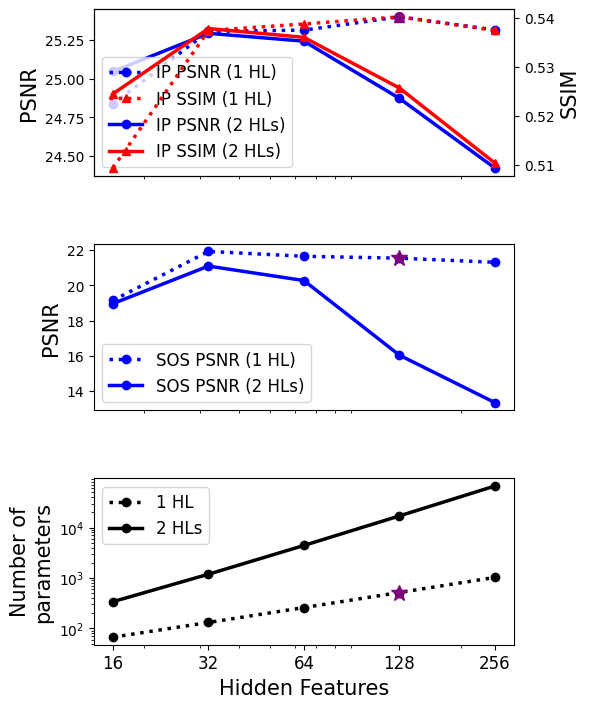

In [139]:
fig = plt.figure(figsize=(6,9))
ax1 = plt.subplot(4,1,1)
ax2 = ax1.twinx()
line_psnr1 = ax1.plot(hidden_fts_list, ip_psnrs[:,0,:].mean(0), label='IP PSNR (1 HL)', linestyle=':', marker='o', color='blue', linewidth=2.5)
line_ssim1 = ax2.plot(hidden_fts_list, ip_ssims[:,0,:].mean(0), label='IP SSIM (1 HL)', linestyle=':', marker='^', color='red', linewidth=2.5)
line_psnr2 = ax1.plot(hidden_fts_list, ip_psnrs[:,1,:].mean(0), label='IP PSNR (2 HLs)', marker='o', color='blue', linewidth=2.5)
line_ssim2 = ax2.plot(hidden_fts_list, ip_ssims[:,1,:].mean(0), label='IP SSIM (2 HLs)', marker='^', color='red', linewidth=2.5)
ax1.plot([hidden_fts_list[3]], [ip_psnrs[:,0,3].mean(0)], marker='o', color='purple', markersize=7)
ax2.plot([hidden_fts_list[3]], [ip_ssims[:,0,3].mean(0)], marker='^', color='purple', markersize=7)
ax1.set_ylabel('PSNR', fontsize=15)
ax2.set_ylabel('SSIM', fontsize=15)
# ax1.set_ylim([24.0, 25.7])
# ax2.set_ylim([0.52, 0.563])
ax1.set_xscale('log')
ax1.set_xticks([])
ax2.set_xscale('log')
ax2.set_xticks([])
lns1 = line_psnr1 + line_ssim1 + line_psnr2 + line_ssim2
labels1 = [l.get_label() for l in lns1]
ax1.legend(lns1, labels1, fontsize=12, loc='lower left')

ax = plt.subplot(4,1,2)
ax.plot(hidden_fts_list, sos_psnrs[:,0,:].mean(0), label='SOS PSNR (1 HL)', linestyle=':', marker='o', color='blue', linewidth=2.5)
ax.plot(hidden_fts_list, sos_psnrs[:,1,:].mean(0), label='SOS PSNR (2 HLs)', marker='o', color='blue', linewidth=2.5)
ax.plot([hidden_fts_list[3]], [sos_psnrs[:,0,3].mean(0)], marker='*', color='purple', markersize=12, mew=1)
# ax.set_ylim([14.8, 17.6])
ax.set_xscale('log')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xticks([])
ax.legend(fontsize=12, loc='lower left')

ax = plt.subplot(4,1,3)
ax.plot(hidden_fts_list, n_params[0,0,:], label='1 HL', linestyle=':', marker='o', color='black', linewidth=2.5)
ax.plot(hidden_fts_list, n_params[0,1,:], label='2 HLs', marker='o', color='black', linewidth=2.5)
ax.plot([hidden_fts_list[3]], [n_params[0,0,3]], marker='*', color='purple', markersize=12, mew=1)
# ax.set_ylim([68.5, 71])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of\nparameters', fontsize=15)
ax.set_xticks([16,32,64,128,256], ['16','32','64','128','256'], fontsize=12)
ax.set_xlabel('Hidden Features', fontsize=15)
ax.legend(fontsize=12, loc='upper left')

# ax = plt.subplot(4,1,4)
# ax.plot(hidden_fts_list, times[:,0,:].mean(0), label='Time (1 HL)', linestyle=':', marker='o', color='black', linewidth=2.5)
# ax.plot(hidden_fts_list, times[:,1,:].mean(0), label='Time (2 HLs)', marker='o', color='black', linewidth=2.5)
# ax.plot([hidden_fts_list[3]], [times[:,0,3].mean(0)], marker='*', color='purple', markersize=12, mew=1)
# # ax.set_ylim([68.5, 71])
# ax.set_xscale('log')
# ax.set_ylabel('Time (s)', fontsize=15)
# ax.set_xticks([])
# ax.legend(fontsize=12, loc='upper left')

plt.tight_layout()
plt.savefig('figure_ablation_network.png', bbox_inches='tight', dpi=128)